In [3]:
###########################
# Configs
# #########################

vocab_size= _        # Vocabulary size. Will be determined by the lenght of preprocessed training set after the initial treatement
embedding_dim = 32         # Lenght of vectors representing words
max_length = 18         # Maximal phrase length before processing
trunc_type='post'        # Trunking method for exceeding length>max_lengh
padding_type='post'      # Padding parameters
oov_tok='<OOV>'          # Missing word token
#training_size=22000
num_epochs = 10     
PATIENCE_STOPPING = 5
OPTIMIZER = 'adam'  #Gradient descent optimisation

In [4]:
#Imports###########################################
import os
import io
#Data import
print("Imported data: ")
for dirname, _, filenames in os.walk('/content/drive/MyDrive/NLPW'): #Set your path here
    for filename in filenames:
        print(os.path.join(dirname, filename))

import numpy as np 
import pandas as pd       
import random
import nltk
import tensorflow as tf

print("\n"+"TF version: {}".format(tf.__version__))
vers_tf = int((tf.__version__).split(sep='.')[0])

if vers_tf < 2:
    print('Version < 2 : eager execution enabled')
    tf.enable_eager_execution()

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

Imported data: 
/content/drive/MyDrive/NLPW/Train.csv
/content/drive/MyDrive/NLPW/Test.csv
/content/drive/MyDrive/NLPW/Train.gsheet

TF version: 2.3.0


In that scenario we will be using .csv training set. We'll import it as pandas dataframe.

In [5]:
df = pd.read_csv("/content/drive/MyDrive/NLPW/Train.csv")
#Showing dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              15000 non-null  object
 1   comment         15000 non-null  object
 2   date            15000 non-null  object
 3   down            15000 non-null  int64 
 4   parent_comment  15000 non-null  object
 5   score           15000 non-null  int64 
 6   top             15000 non-null  int64 
 7   topic           15000 non-null  object
 8   user            15000 non-null  object
 9   label           15000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 1.1+ MB


In [6]:
df.head()

,ID,comment,date,down,parent_comment,score,top,topic,user,label
0,uid_590555,"Well, let's be honest here, they don't actuall...",2015-04,0,They should shut the fuck up and let the commu...,2,2,starcitizen,Combat_Wombatz,0
1,uid_671762,"Well, I didn't need evidence to believe in com...",2016-12,-1,You need evidence to kill people? I thought we...,6,-1,EnoughCommieSpam,starkadd,1
2,uid_519689,"Who does an ""official promo"" in 360p?",2013-11,0,2014 BMW S1000R: Official Promo,3,3,motorcycles,phybere,0
3,uid_788362,Grotto koth was the best,2015-09,0,Not really that memorable lol if you want memo...,2,2,hcfactions,m0xyMC,1
4,uid_299252,Neal's back baby,2015-11,0,James Neal hit on Zach Parise,-5,-5,hockey,Somuch101,1


In [8]:
n_sarcastic = (df['label'] == 1).sum()
n_not_sarcastic = (df['label'] == 0).sum()
print("Where is {} sarcastic comments and {} not sarcastic comments inthis dataset".format(n_sarcastic, n_not_sarcastic))

Where is 7527 sarcastic comments and 7473 not sarcastic comments inthis dataset


In [9]:
#We can see the exemple of some of them:
for i in range(3):
    n = random.randrange(len(df['comment']))
    print('Parent comment: '+df['parent_comment'][n])
    print('Comment: '+df['comment'][n])
    print('Score: '+str(df['score'][n]))
    print("Is sarcasm: {}".format(df['label'][n]))
    print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

Parent comment: Speculation on Steven's Stagnation So, other than the fact that Steven wants to retain the carefreeness of being a child, I think he wants to be perceived as such as well. Children can convey innocence, preciousness, a non threatening aura (okay it depends on who you are and whether or not the child is a hell spawn but regardless). If people perceive Steven as non threatening then they're more likely to trust him, to care for him, to believe him. There is so much stigma behind being a teenager. Lars is a perfect example of hormones hijacking your brain and sense of morality. Perhaps Steven noticed how people treated Lars and subconsciously sought to avoid that. Or maybe I'm reading too much into it. *Shrugs.** It could also be that he is just not ready to grow to that phase yet. Or some sort of gem related maturation thingy.
Comment: It's a shout out to twilight, since it's such a great piece of art
Score: 1
Is sarcasm: 1
||||||||||||||||||||||||||||||||||||||||||||||||

In [10]:
# Contruction des listes de phrases(X) et de labels(y)
X=list(df['comment'])
#Xp=list(df['parent_comment'])
#Xt=list(test_df['comment'])
y=list(df['label'])
#s=list(df['score'])

print(len(set(X))) #Vocab size before preprocessing

14871


Preprocessing: stopwords+lemmatization.

In [11]:
# Importing NLTK stopwords
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
#Stop-words removing function
def process_stop_words(X,DEL_STOPWORDS, display_res=True):
    
    if DEL_STOPWORDS: #Used for different treatements
        X_seq = [[word for word in word_tokenize(st)] for st in X]
        
        X_seq_no_stops = [[word for word in st if word not in stopwords] for st in X_seq]
        
        if display_res:
            print("Before tokenization:     {}".format(X[10]))
            print("After tokenization:     {}".format(X_seq[10]))
            print("Whithout stopwords:         {}".format(X_seq_no_stops[10]))
        return X_seq_no_stops
    else:
        print("No stopwords treatement")
        return X

We will use different preprocessings on our dataset:

In [13]:
X_processed=process_stop_words(X,True)
print('||||||||||||||||||||||||||||||||||||||||||')
X_baren=process_stop_words(X,False)

Before tokenization:     That's gonna look great later in life
After tokenization:     ['That', "'s", 'gon', 'na', 'look', 'great', 'later', 'in', 'life']
Whithout stopwords:         ['That', "'s", 'gon', 'na', 'look', 'great', 'later', 'life']
||||||||||||||||||||||||||||||||||||||||||
No stopwords treatement


In [14]:
def process_lemmatization(X, DO_LEMMATIZE,DEL_STOPWORDS, display_res=True):
    if DO_LEMMATIZE:##Used in different preprocessing
        lemm = WordNetLemmatizer()
        if display_res:
            print("Before lemmatization :    {}".format(X[10]))
        Xlem = X.copy()
        if DEL_STOPWORDS:
            Xlem = [[lemm.lemmatize(word) for word in s] for s in X]
        else:
            Xlem = [[lemm.lemmatize(word) for word in word_tokenize(s)] for s in X]

        if display_res:
            print("After Lemmatization :    {}".format(Xlem[10]))
        return Xlem
    else:
        if DEL_STOPWORDS:
          print("No treatement")
          return X
        else:
          X_seqq = [[word for word in word_tokenize(st)] for st in X]
          return(X_seqq)

In [15]:
X_processed_nolem = process_lemmatization(X_processed,False,True)
X_processed_lem = process_lemmatization(X_processed,True,True)
X_baren_nolem = process_lemmatization(X_baren,False,False)
X_baren_lem = process_lemmatization(X_baren,True,False)


X_processed_nolem_flat = set([w for sublist in X_processed_nolem for w in sublist])
X_processed_lem_flat = set([w for sublist in X_processed_lem for w in sublist])
X_baren_nolem_flat = set([w for sublist in X_baren_nolem for w in sublist])
X_baren_lem_flat = set([w for sublist in X_baren_lem for w in sublist])
print('/././././././././././././././.././././//./././././././')
print('With stopwords no lemmatization vocabulary size : '+str(len(X_baren_nolem_flat)))##Vocab size after preprocessing
print('Removed stopwords, no lemmatization vocabulary size: '+str(len(X_processed_nolem_flat)))##Vocab size after preprocessing
print('With stopwords lemmatization vocabulary size: '+str(len(X_baren_lem_flat)))##Vocab size after preprocessing
print('Removed stopwords lemmatization vocabulary size: '+str(len(X_processed_lem_flat)))##Vocab size after preprocessing
#################USED IN FURTHER TREATEMENT
pnl_vocab_size = len(X_processed_nolem_flat) ##NOSTOPS|NOLEM##
pl_vocab_size = len(X_processed_lem_flat) ##NOSTOPS|LEM##
bnl_vocab_size = len(X_baren_nolem_flat)  ##WITHSTOPS|NOLEM##
bl_vocab_size = len(X_baren_lem_flat)     ##WITHSTOPS|LEM##

No treatement
Before lemmatization :    ['That', "'s", 'gon', 'na', 'look', 'great', 'later', 'life']
After Lemmatization :    ['That', "'s", 'gon', 'na', 'look', 'great', 'later', 'life']
Before lemmatization :    That's gonna look great later in life
After Lemmatization :    ['That', "'s", 'gon', 'na', 'look', 'great', 'later', 'in', 'life']
/././././././././././././././.././././//./././././././
With stopwords no lemmatization vocabulary size : 21896
Removed stopwords, no lemmatization vocabulary size: 21764
With stopwords lemmatization vocabulary size: 20443
Removed stopwords lemmatization vocabulary size: 20325


We can observe that no-stopwords, lemmatization vocabulary size is the smallest, which is quite logical.

Splitting training set on training and test:

In [16]:
def splitting(X):
  training_size=int(len(X)//1.5)
  X_train = X[:training_size]
  y_train = np.array(y[:training_size])
  X_test  = X[training_size:len(X)-100]
  y_test  = np.array(y[training_size:len(X)-100])
  X_valid = X[len(X)-100:]
  y_valid = np.array(y[len(X)-100:])
  print(len(X))

  print("Training set size : {}".format(len(X_train)))
  print("Test set size : {}".format(len(X_test)))
  RES=[[X_train,y_train],[X_test,y_test],[X_valid,y_valid]]
  return(RES)

In [17]:
pnl = splitting(X_processed_nolem) 
pl = splitting(X_processed_lem) 
bnl = splitting(X_baren_nolem)  
bl = splitting(X_baren_lem)

15000
Training set size : 10000
Test set size : 4900
15000
Training set size : 10000
Test set size : 4900
15000
Training set size : 10000
Test set size : 4900
15000
Training set size : 10000
Test set size : 4900


Sentence tokenisation:

In [18]:
#Tokenizer creaion function
def create_tokenizer(vocab_size,X_train):
  tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok)
  tokenizer.fit_on_texts(X_train)
  word_index = tokenizer.word_index                             
  X_train_sequences = tokenizer.texts_to_sequences(X_train)
  X_train_padded = pad_sequences(X_train_sequences, maxlen = max_length, truncating = trunc_type)
  RES=[tokenizer,X_train_sequences,X_train_padded]
  return RES

In [19]:
tokenizer_bnl=create_tokenizer(bnl_vocab_size,bnl[0][0])[0]
tokenizer_bl=create_tokenizer(bl_vocab_size,bl[0][0])[0]
tokenizer_pnl=create_tokenizer(pnl_vocab_size,pnl[0][0])[0]
tokenizer_pl=create_tokenizer(pl_vocab_size,pl[0][0])[0]

X_train_sequences_bnl=create_tokenizer(bnl_vocab_size,bnl[0][0])[1]
X_train_sequences_bl=create_tokenizer(bl_vocab_size,bl[0][0])[1]
X_train_sequences_pnl=create_tokenizer(pnl_vocab_size,pnl[0][0])[1]
X_train_sequences_pl=create_tokenizer(pl_vocab_size,pl[0][0])[1]

X_train_padded_bnl=create_tokenizer(bnl_vocab_size,bnl[0][0])[2]
X_train_padded_bl=create_tokenizer(bl_vocab_size,bl[0][0])[2]
X_train_padded_pnl=create_tokenizer(pnl_vocab_size,pnl[0][0])[2]
X_train_padded_pl=create_tokenizer(pl_vocab_size,pl[0][0])[2]

In [21]:
bnl_X_test_sequences = tokenizer_bnl.texts_to_sequences(bnl[1][0])
bnl_X_test_padded = pad_sequences(bnl_X_test_sequences, maxlen = max_length, truncating = trunc_type)

bl_X_test_sequences = tokenizer_bl.texts_to_sequences(bl[1][0])
bl_X_test_padded = pad_sequences(bl_X_test_sequences, maxlen = max_length, truncating = trunc_type)

pnl_X_test_sequences = tokenizer_pnl.texts_to_sequences(pnl[1][0])
pnl_X_test_padded = pad_sequences(pnl_X_test_sequences, maxlen = max_length, truncating = trunc_type)

pl_X_test_sequences = tokenizer_pl.texts_to_sequences(pl[1][0])
pl_X_test_padded = pad_sequences(pl_X_test_sequences, maxlen = max_length, truncating = trunc_type)

In [36]:
#Might be useful. Needs to be implemented for each type of preprocessing (word_index taken from function create_tokenizer)
# Inversed index creation
#reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
#def decode_review(text):
#    return ' '.join([reverse_word_index.get(i, '?') for i in text])

# Showing some random comments:
#for i in range(3):
#    alea = random.randrange(len(pnl[0][0]))
#    print("Original comment: {}".format(pnl[0][0][alea]))
#    print("Sequence : {}".format(X_train_sequences_pnl[alea]))
#    print("Sequenc + padding: {}".format(X_train_padded_pnl[alea]))
#    print("Rbuild: {}".format(decode_review(X_train_padded_pnl[alea])))
#    print("----------------------------------------------------------------------")

In [23]:
def build_model(vocab_size):
  model = tf.keras.Sequential([
    
      #Input layer
      tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    
      #LSTM layer
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    
      #CN layer
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dropout(0.5),
    
      #Output layer
      tf.keras.layers.Dense(1, activation='sigmoid')
      ])

  model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy', metrics=['acc'])
  model.summary()
  return(model)

In [24]:
Model_bnl=build_model(bnl_vocab_size)
print('|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||')
Model_bl=build_model(bl_vocab_size)
print('|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||')
Model_pnl=build_model(pnl_vocab_size)
print('|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||')
Model_pl=build_model(pl_vocab_size)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 18, 32)            700672    
_________________________________________________________________
bidirectional (Bidirectional (None, 18, 64)            16640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0

In [25]:
# Callbacks
checkpoint = ModelCheckpoint("/content/drive/MyDrive/NLPW/Callbacks/model_sarcasm.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=PATIENCE_STOPPING, verbose=1, mode='auto')##Stopping epochs if loss function starts to grow

In [26]:
#Model training With stopwords and no lem training
import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"###No warnings

history=Model_bnl.fit(X_train_padded_bnl,
                  bnl[0][1],
                  epochs=num_epochs,
                  validation_data=(bnl_X_test_padded, bnl[1][1]),
                  callbacks = [checkpoint, early],
                  verbose=1)

Epoch 1/10
313/313 [==============================] - 12s 40ms/step - loss: 0.6924 - acc: 0.5124 - val_loss: 0.6852 - val_acc: 0.5596
Epoch 2/10
313/313 [==============================] - 11s 34ms/step - loss: 0.6413 - acc: 0.6533 - val_loss: 0.6343 - val_acc: 0.6398
Epoch 3/10
313/313 [==============================] - 10s 33ms/step - loss: 0.4963 - acc: 0.7918 - val_loss: 0.6744 - val_acc: 0.6284
Epoch 4/10
313/313 [==============================] - 10s 33ms/step - loss: 0.3320 - acc: 0.8812 - val_loss: 0.8249 - val_acc: 0.6182
Epoch 5/10
313/313 [==============================] - 10s 33ms/step - loss: 0.2169 - acc: 0.9305 - val_loss: 1.0784 - val_acc: 0.6086
Epoch 6/10
313/313 [==============================] - 10s 33ms/step - loss: 0.1640 - acc: 0.9505 - val_loss: 1.3555 - val_acc: 0.6020
Epoch 7/10
313/313 [==============================] - 10s 33ms/step - loss: 0.1289 - acc: 0.9598 - val_loss: 1.6295 - val_acc: 0.5965
Epoch 00007: early stopping


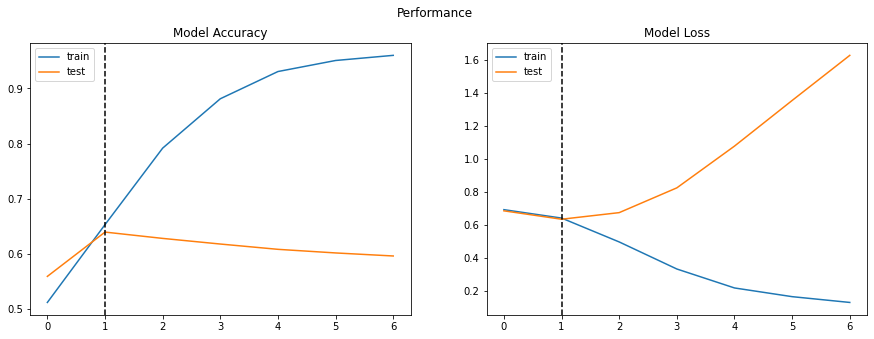

In [27]:
# Learning graph

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance")
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
vline_cut = np.where(history.history['val_acc'] == np.max(history.history['val_acc']))[0][0]
ax1.axvline(x=vline_cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'test'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=vline_cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'test'])
plt.show()

In [28]:
#Model With stopwords and lemmatization training
import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"###No warnings

history=Model_bl.fit(X_train_padded_bl,
                  bl[0][1],
                  epochs=num_epochs,
                  validation_data=(bl_X_test_padded, bl[1][1]),
                  callbacks = [checkpoint, early],
                  verbose=1)

Epoch 1/10
313/313 [==============================] - 12s 38ms/step - loss: 0.6852 - acc: 0.5372 - val_loss: 0.6596 - val_acc: 0.5965
Epoch 2/10
313/313 [==============================] - 10s 33ms/step - loss: 0.5985 - acc: 0.6979 - val_loss: 0.6326 - val_acc: 0.6418
Epoch 3/10
313/313 [==============================] - 10s 33ms/step - loss: 0.4492 - acc: 0.8128 - val_loss: 0.6767 - val_acc: 0.6292
Epoch 4/10
313/313 [==============================] - 10s 33ms/step - loss: 0.3078 - acc: 0.8870 - val_loss: 0.8839 - val_acc: 0.6167
Epoch 5/10
313/313 [==============================] - 10s 33ms/step - loss: 0.2157 - acc: 0.9289 - val_loss: 1.0994 - val_acc: 0.6151
Epoch 6/10
313/313 [==============================] - 10s 33ms/step - loss: 0.1630 - acc: 0.9459 - val_loss: 1.2641 - val_acc: 0.6210
Epoch 7/10
313/313 [==============================] - 10s 33ms/step - loss: 0.1283 - acc: 0.9547 - val_loss: 1.8249 - val_acc: 0.6061
Epoch 00007: early stopping


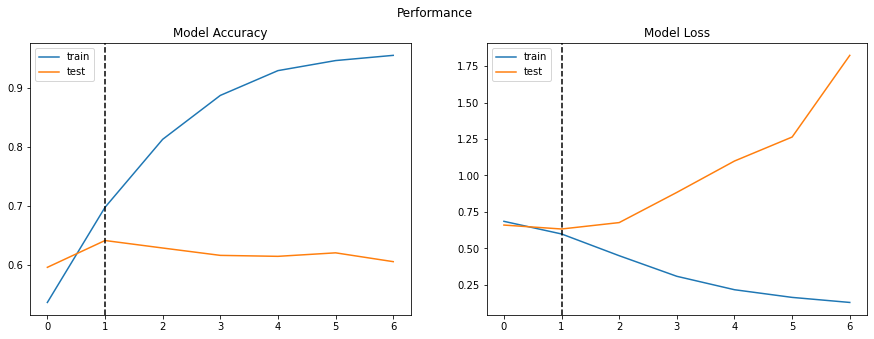

In [29]:
# Graph

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance")
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
vline_cut = np.where(history.history['val_acc'] == np.max(history.history['val_acc']))[0][0]
ax1.axvline(x=vline_cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'test'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=vline_cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'test'])
plt.show()

In [30]:
#Model Without stopwords and no lemmatization training
import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"###No warnings

history=Model_pnl.fit(X_train_padded_pnl,
                  pnl[0][1],
                  epochs=num_epochs,
                  validation_data=(pnl_X_test_padded, pnl[1][1]),
                  callbacks = [checkpoint, early],
                  verbose=1)

Epoch 1/10
313/313 [==============================] - 12s 39ms/step - loss: 0.6907 - acc: 0.5140 - val_loss: 0.6726 - val_acc: 0.5935
Epoch 2/10
313/313 [==============================] - 11s 35ms/step - loss: 0.6181 - acc: 0.6766 - val_loss: 0.6283 - val_acc: 0.6373
Epoch 3/10
313/313 [==============================] - 11s 35ms/step - loss: 0.4439 - acc: 0.8150 - val_loss: 0.7176 - val_acc: 0.6243
Epoch 4/10
313/313 [==============================] - 10s 33ms/step - loss: 0.2881 - acc: 0.8951 - val_loss: 0.9379 - val_acc: 0.6231
Epoch 5/10
313/313 [==============================] - 10s 33ms/step - loss: 0.1968 - acc: 0.9319 - val_loss: 1.2138 - val_acc: 0.6196
Epoch 6/10
313/313 [==============================] - 11s 34ms/step - loss: 0.1466 - acc: 0.9515 - val_loss: 1.4861 - val_acc: 0.6108
Epoch 7/10
313/313 [==============================] - 11s 35ms/step - loss: 0.1185 - acc: 0.9605 - val_loss: 1.4961 - val_acc: 0.6035
Epoch 00007: early stopping


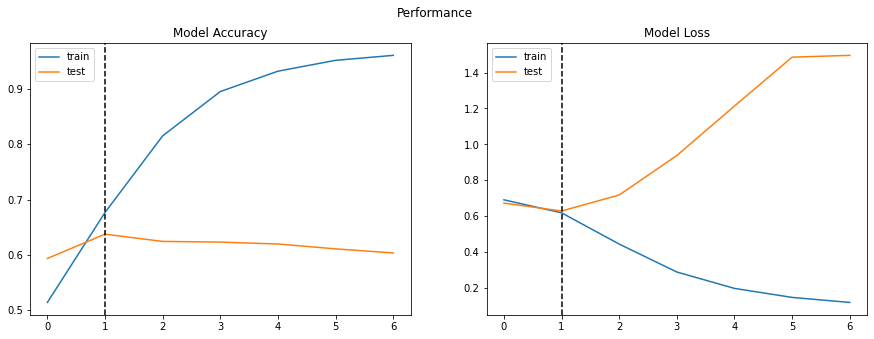

In [31]:
# Graph

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance")
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
vline_cut = np.where(history.history['val_acc'] == np.max(history.history['val_acc']))[0][0]
ax1.axvline(x=vline_cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'test'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=vline_cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'test'])
plt.show()

In [32]:
#Model Without stopwords and lemmatization training
import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"###No warnings

history=Model_pl.fit(X_train_padded_pl,
                  pl[0][1],
                  epochs=num_epochs,
                  validation_data=(pl_X_test_padded, pl[1][1]),
                  callbacks = [checkpoint, early],
                  verbose=1)

Epoch 1/10
313/313 [==============================] - 12s 37ms/step - loss: 0.6893 - acc: 0.5245 - val_loss: 0.6615 - val_acc: 0.6110
Epoch 2/10
313/313 [==============================] - 10s 33ms/step - loss: 0.6085 - acc: 0.6832 - val_loss: 0.6271 - val_acc: 0.6463
Epoch 3/10
313/313 [==============================] - 10s 33ms/step - loss: 0.4518 - acc: 0.8090 - val_loss: 0.7158 - val_acc: 0.6459
Epoch 4/10
313/313 [==============================] - 11s 34ms/step - loss: 0.3097 - acc: 0.8886 - val_loss: 0.8645 - val_acc: 0.6212
Epoch 5/10
313/313 [==============================] - 10s 33ms/step - loss: 0.2120 - acc: 0.9287 - val_loss: 0.9936 - val_acc: 0.6184
Epoch 6/10
313/313 [==============================] - 10s 33ms/step - loss: 0.1593 - acc: 0.9460 - val_loss: 1.3790 - val_acc: 0.6127
Epoch 7/10
313/313 [==============================] - 10s 32ms/step - loss: 0.1207 - acc: 0.9596 - val_loss: 2.1519 - val_acc: 0.6118
Epoch 00007: early stopping


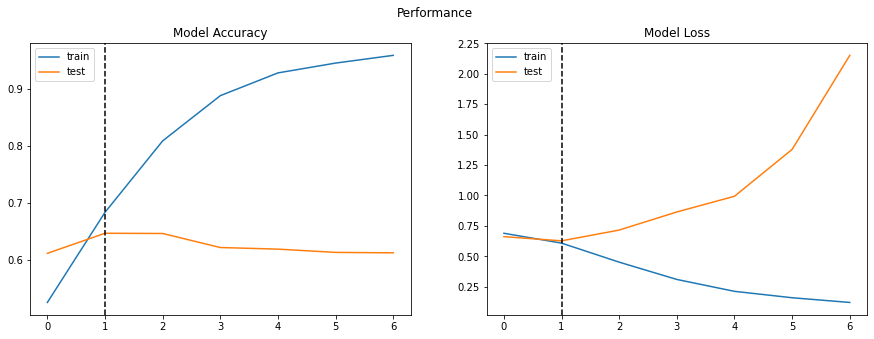

In [33]:
# Graph

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance")
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
vline_cut = np.where(history.history['val_acc'] == np.max(history.history['val_acc']))[0][0]
ax1.axvline(x=vline_cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'test'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=vline_cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'test'])
plt.show()

As we can see, the best result is provided by the model without any preprocessing (NO stopwords removal, NO lemmatization). This is logical as we are studiyng sarcasms, which means that punctuation and conjugation are important.

On voit grace aux graphes, que le meilleur résultat est obtenu avec le modèle sans lemmatisation et en gardant les stops Words. C'est logique, car dans l'étude de sarcasme la punctuation et la conjugaison des mots sont importantes, ainsi que les stop words.